In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
# Time Series
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller, kpss

In [206]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
import warnings

# turn off slice warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

In [4]:
plt.rcParams['figure.figsize'] = [12, 8]

In [5]:
store_format_df = pd.read_parquet('../Data/store_format_agg/store_format_agg.parquet')

In [6]:
store_format_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SHOP_DATE     3276 non-null   object 
 1   STORE_FORMAT  3276 non-null   object 
 2   TOTAL_QTY     3276 non-null   float64
 3   TOTAL_SPEND   3276 non-null   float64
dtypes: float64(2), object(2)
memory usage: 102.5+ KB


In [7]:
# SHOP_DATE should be a date field.
store_format_df['SHOP_DATE'] = pd.to_datetime(store_format_df['SHOP_DATE'])

In [8]:
store_format_df['SHOP_MONTH'] = store_format_df['SHOP_DATE'].dt.month_name()
store_format_df['SHOP_QUARTER'] = store_format_df['SHOP_DATE'].dt.quarter
store_format_df['SHOP_YEAR'] = store_format_df['SHOP_DATE'].dt.year

In [9]:
store_format_df = store_format_df.set_index('SHOP_DATE', drop=True).sort_index()

In [10]:
store_format_df.head()

,STORE_FORMAT,TOTAL_QTY,TOTAL_SPEND,SHOP_MONTH,SHOP_QUARTER,SHOP_YEAR
SHOP_DATE,,,,,,
2006-04-10,LS,33945.0,45132.26,April,2,2006
2006-04-10,SS,3711.0,4483.13,April,2,2006
2006-04-10,XLS,4793.0,6256.27,April,2,2006
2006-04-10,MS,10996.0,14203.70,April,2,2006
2006-04-11,SS,3396.0,3995.99,April,2,2006


In [11]:
store_format_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3276 entries, 2006-04-10 to 2008-07-06
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   STORE_FORMAT  3276 non-null   object 
 1   TOTAL_QTY     3276 non-null   float64
 2   TOTAL_SPEND   3276 non-null   float64
 3   SHOP_MONTH    3276 non-null   object 
 4   SHOP_QUARTER  3276 non-null   int64  
 5   SHOP_YEAR     3276 non-null   int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 179.2+ KB


In [12]:
store_format_df.head()

,STORE_FORMAT,TOTAL_QTY,TOTAL_SPEND,SHOP_MONTH,SHOP_QUARTER,SHOP_YEAR
SHOP_DATE,,,,,,
2006-04-10,LS,33945.0,45132.26,April,2,2006
2006-04-10,SS,3711.0,4483.13,April,2,2006
2006-04-10,XLS,4793.0,6256.27,April,2,2006
2006-04-10,MS,10996.0,14203.70,April,2,2006
2006-04-11,SS,3396.0,3995.99,April,2,2006


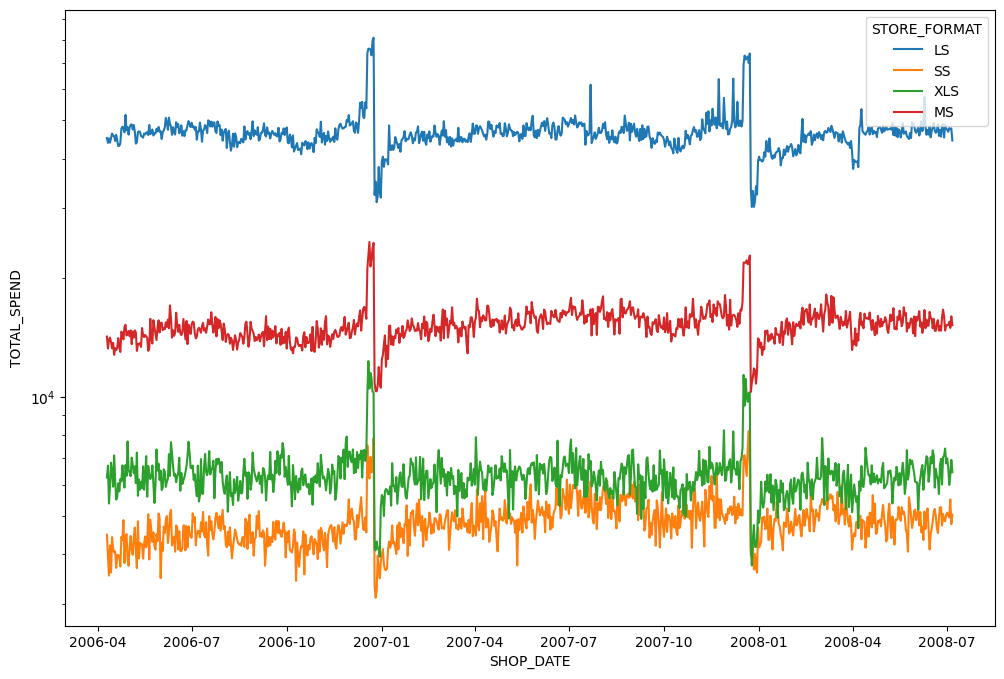

In [13]:
lp = sns.lineplot(data=store_format_df, x='SHOP_DATE', y='TOTAL_SPEND', hue='STORE_FORMAT', estimator='sum')
lp.set_yscale('log')

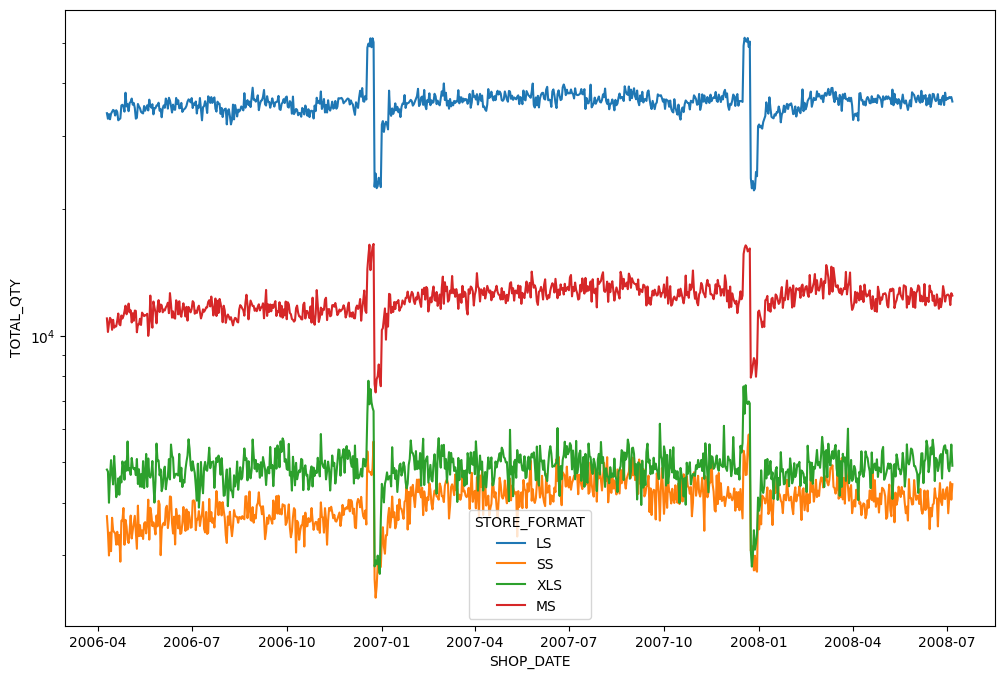

In [14]:
lp = sns.lineplot(data=store_format_df, x='SHOP_DATE', y='TOTAL_QTY', hue='STORE_FORMAT', estimator='sum')
lp.set_yscale('log')

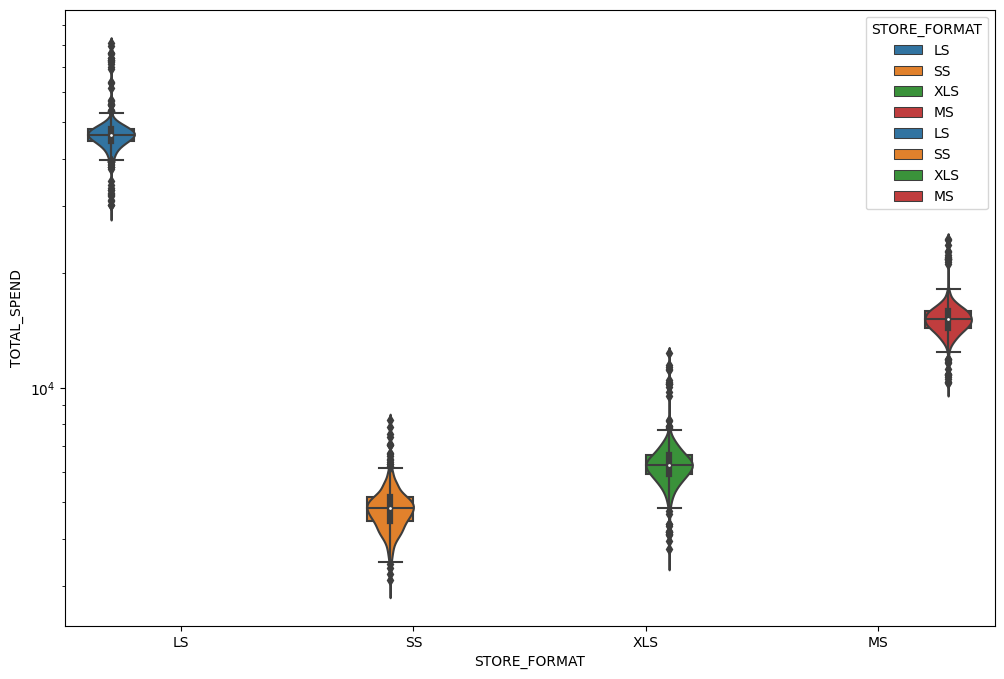

In [15]:
vp = sns.violinplot(data=store_format_df, x='STORE_FORMAT', y='TOTAL_SPEND', hue='STORE_FORMAT')
sns.boxplot(data=store_format_df, x='STORE_FORMAT', y='TOTAL_SPEND', hue='STORE_FORMAT')
vp.set_yscale('log')

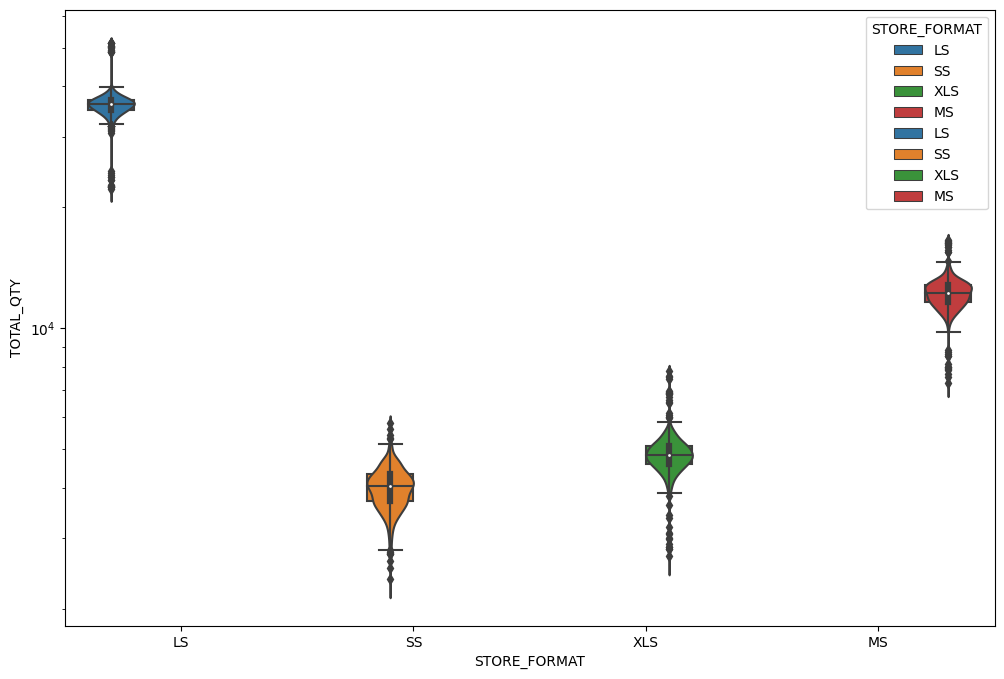

In [16]:
vp = sns.violinplot(data=store_format_df, x='STORE_FORMAT', y='TOTAL_QTY', hue='STORE_FORMAT')
sns.boxplot(data=store_format_df, x='STORE_FORMAT', y='TOTAL_QTY', hue='STORE_FORMAT')
vp.set_yscale('log')

In [17]:
# What are the different types of store format?
store_format_df['STORE_FORMAT'].unique()

array(['LS', 'SS', 'XLS', 'MS'], dtype=object)

In [18]:
def get_sorted_store_format_ts(df, format_type):
    return store_format_df.query(f"STORE_FORMAT == '{format_type}'").sort_index()

In [19]:
store_ss = get_sorted_store_format_ts(store_format_df, 'SS')
store_ms = get_sorted_store_format_ts(store_format_df, 'MS')
store_ls = get_sorted_store_format_ts(store_format_df, 'LS')
store_xls = get_sorted_store_format_ts(store_format_df, 'XLS')

In [20]:
def plot_ts_plot(df, plot_type, time_granularity):
    """
    Function to display a number of plots for a time series QTY
    """
    
    if plot_type.upper() =='LINE':
        if time_granularity.upper() == 'DATE':
            lp = sns.lineplot(data=df, x=df.index, y='TOTAL_SPEND')
        else:
            lp = sns.lineplot(data=df, x=f'SHOP_{time_granularity}', y='TOTAL_SPEND')
    elif plot_type.upper() == 'BOXPLOT':
        if time_granularity.upper() == 'DATE':
            bp = sns.boxplot(data=df, x=df.index, y='TOTAL_SPEND')
        else:
            bp = sns.boxplot(data=df, x=f'SHOP_{time_granularity}', y='TOTAL_SPEND')
    else:
        print("Unknown plot type - currently supports: 'boxplot' & 'line'")

In [21]:
def plot_ts_decomposition(df):
    """
    Function to accept a time series df and return a naive decomposition.
    """
    
    # Multiplicative Decomposition
    result_mul = seasonal_decompose(df['TOTAL_SPEND'], model='multiplicative', period=365, extrapolate_trend=len(df)) 
    # Additive Decomposition
    result_add = seasonal_decompose(df['TOTAL_SPEND'], model='additive', period=365, extrapolate_trend=len(df))

    result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22) 
    result_add.plot().suptitle('Additive Decompose', fontsize=22) 
    plt.show()

In [91]:
def test_stationarity(df):
    # ADF Test
    adf_result = adfuller(df['TOTAL_SPEND'], autolag='AIC') 
    print(f'ADF Statistic: {adf_result[0]}') 
    print(f'p-value: {adf_result[1]}')
    if adf_result[1] <= 0.05:
        print("Reject Null Hypothesis, p-value <= 0.05, time series is stationary")
        adf_test = True
    else:
        print("Fail to reject Null Hypothesis, p-value > 0.05, time series is non-stationary")
        adf_test= False
    for key, value in adf_result[4].items():
        print('Critial Values:')
        print(f'{key}, {value}')
        
    # KPSS Test
    kpss_result = kpss(df['TOTAL_SPEND'], regression='c') 
    print('\nKPSS Statistic: %f' % kpss_result[0]) 
    print('p-value: %f' % kpss_result[1])
    if kpss_result[1] > 0.05:
        print("Reject Null Hypothesis, p-value > 0.05, time series is stationary")
        kpss_test = False
    else:
        print("Fail to reject Null Hypothesis, p-value <= 0.05, time series is non-stationary")
        kpss_test = True
    for key, value in kpss_result[3].items():
        print('Critial Values:')
        print(f'{key}, {value}')
        
        
    if adf_test and kpss_test:
        print("Both test indicate a stationary time series")
    elif not adf_test and not kpss_test:
        print("Neither test indicates a stationary time series")
    elif not adf_test and kpss_test:
        print("TS appears to be trend stationary, consider detrending the overall.")
    else:
        print("TS appears to be difference stationary, consider differencing the overall")

In [95]:
test_stationarity(store_xls)

ADF Statistic: -10.026000872408984
p-value: 1.6314719537350395e-17
Reject Null Hypothesis, p-value <= 0.05, time series is stationary
Critial Values:
1%, -3.4384289321263126
Critial Values:
5%, -2.865105979079729
Critial Values:
10%, -2.568668841575869

KPSS Statistic: 0.102118
p-value: 0.100000
Reject Null Hypothesis, p-value > 0.05, time series is stationary
Critial Values:
10%, 0.347
Critial Values:
5%, 0.463
Critial Values:
2.5%, 0.574
Critial Values:
1%, 0.739
TS appears to be difference stationary, consider differencing the overall


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


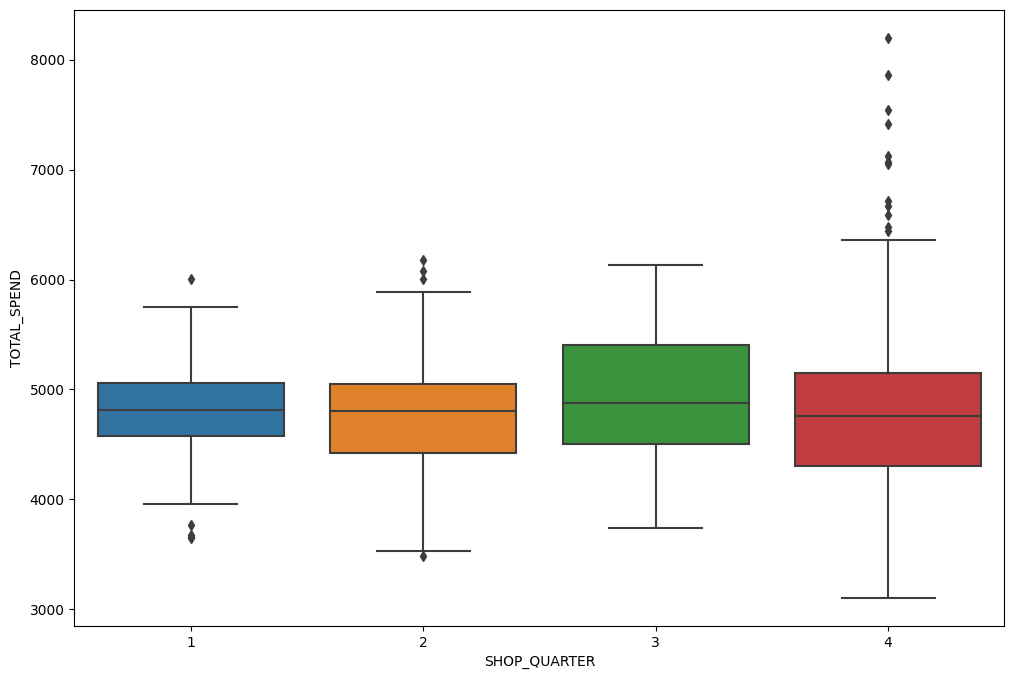

In [99]:
plot_ts_plot(store_ss, 'boxplot', 'QUARTER')

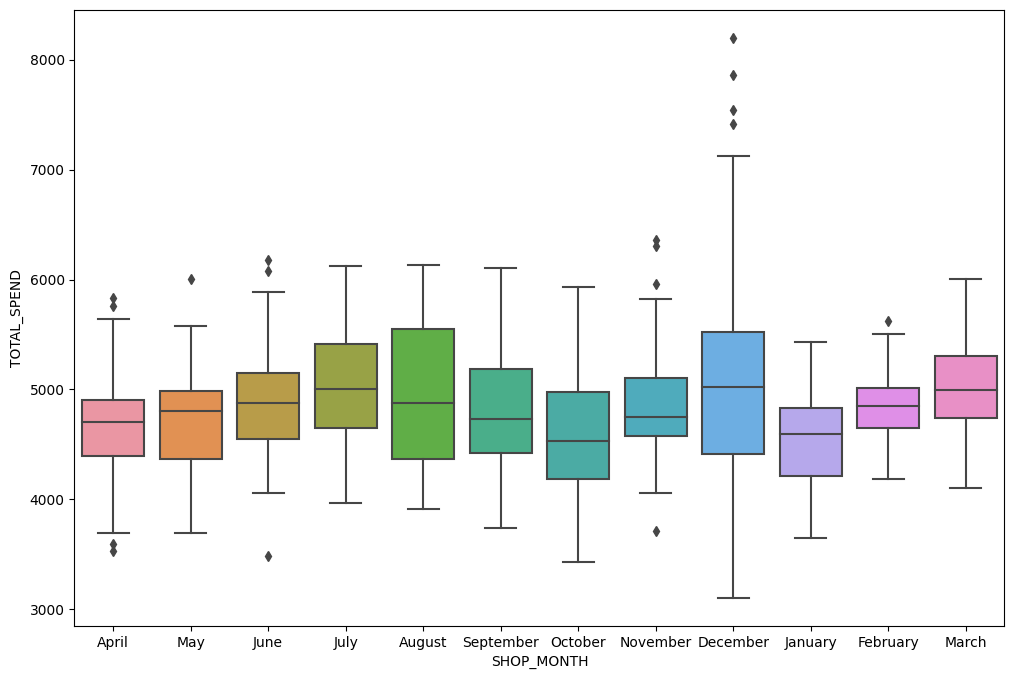

In [100]:
plot_ts_plot(store_ss, 'boxplot', 'MONTH')

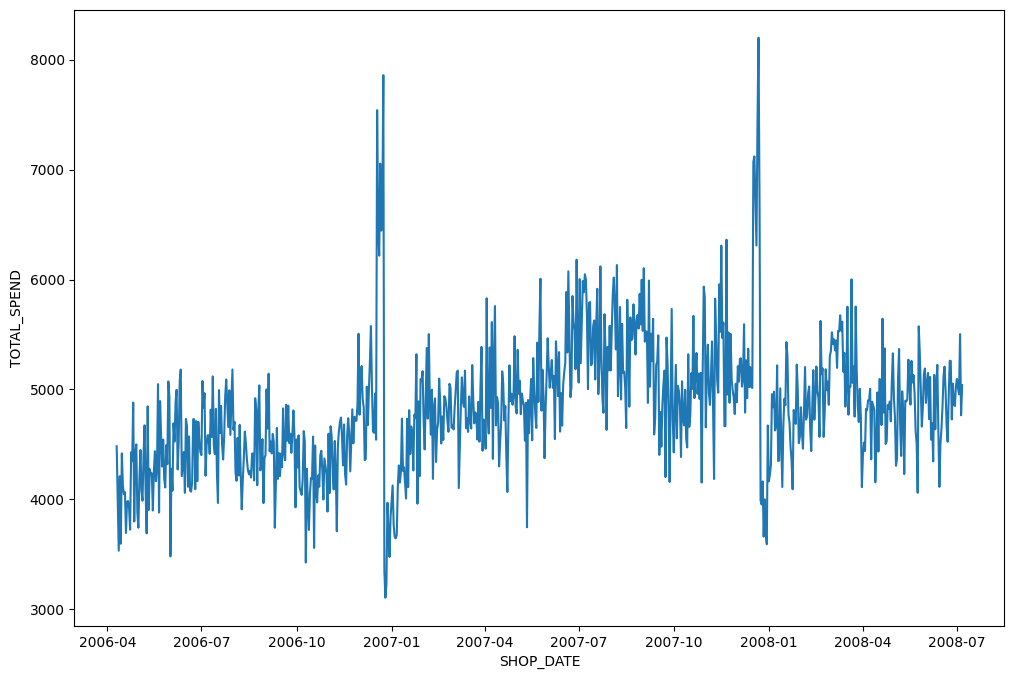

In [101]:
plot_ts_plot(store_ss, 'line', 'DATE')

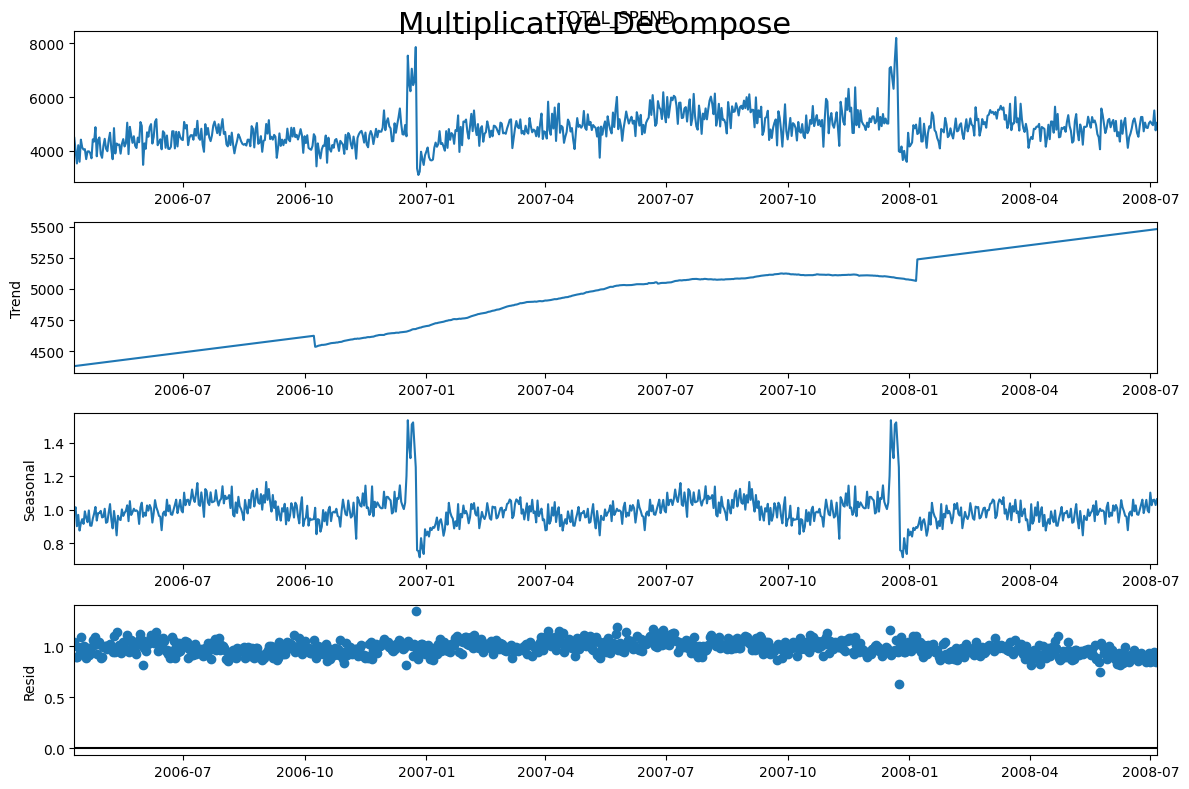

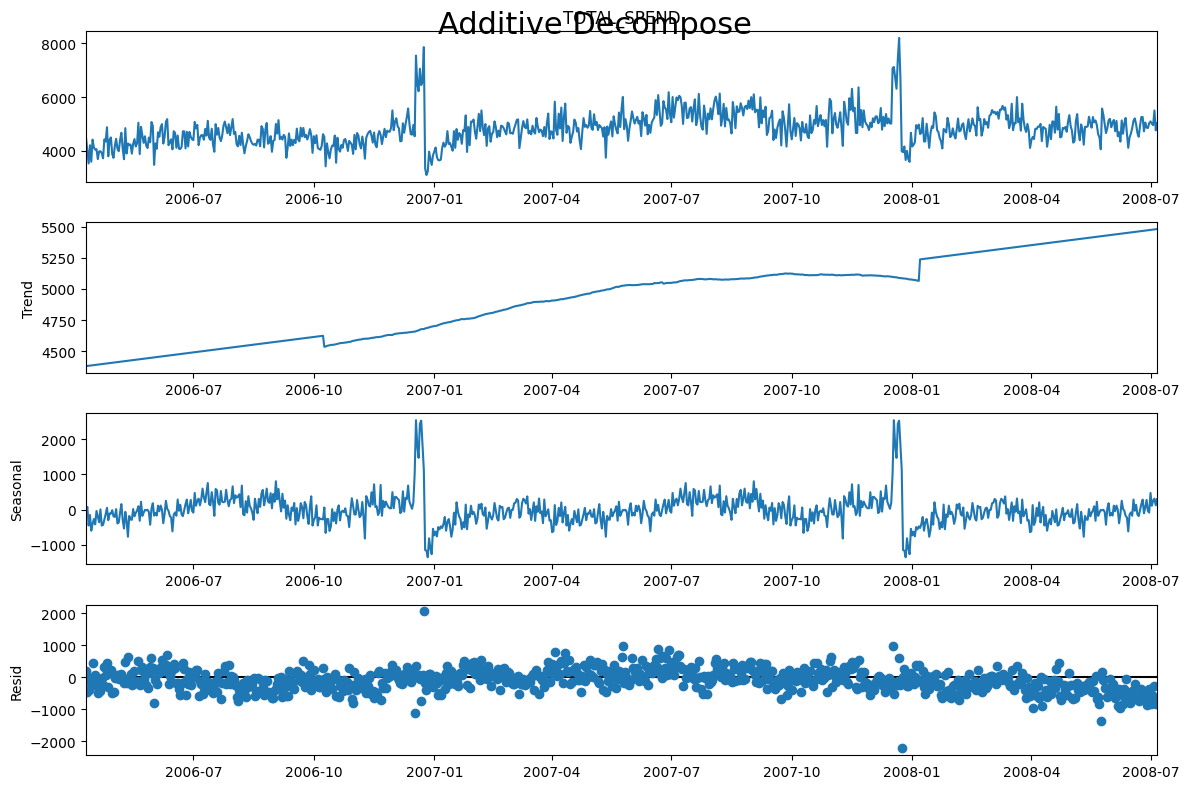

In [102]:
plot_ts_decomposition(store_ss)

SS appears to stationary with a 12 months seasonal component.<br>
No action necessary in pre-processing.

In [103]:
test_stationarity(store_ss)

ADF Statistic: -5.097661179892831
p-value: 1.4171600607797934e-05
Reject Null Hypothesis, p-value <= 0.05, time series is stationary
Critial Values:
1%, -3.4384589869479023
Critial Values:
5%, -2.8651192271940693
Critial Values:
10%, -2.5686758988725416

KPSS Statistic: 2.070406
p-value: 0.010000
Fail to reject Null Hypothesis, p-value <= 0.05, time series is non-stationary
Critial Values:
10%, 0.347
Critial Values:
5%, 0.463
Critial Values:
2.5%, 0.574
Critial Values:
1%, 0.739
Both test indicate a stationary time series


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


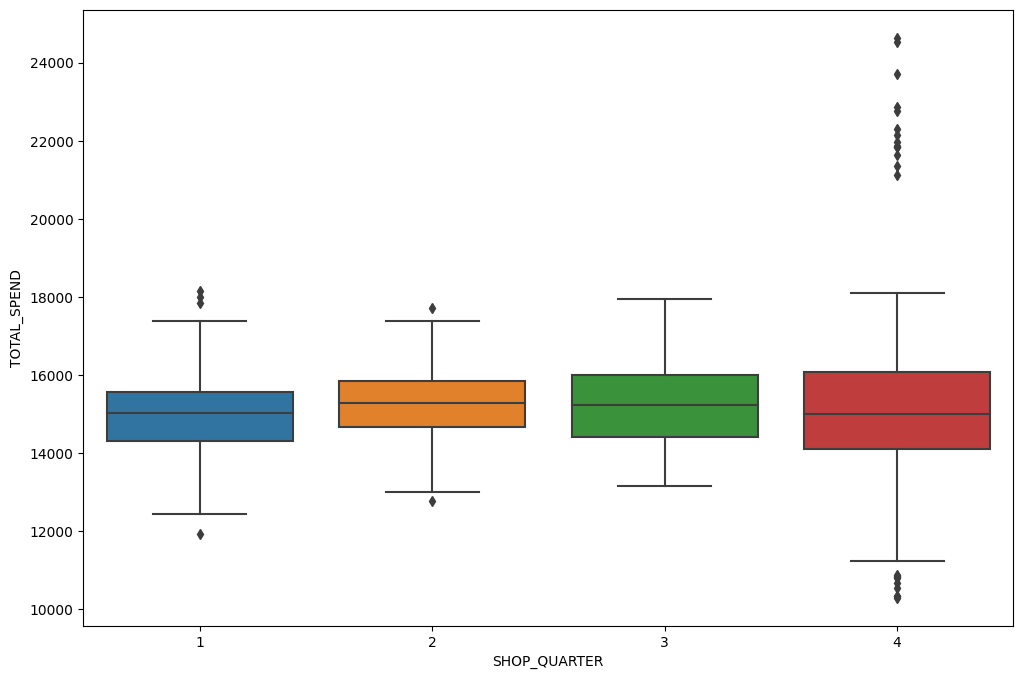

In [104]:
plot_ts_plot(store_ms, 'boxplot', 'QUARTER')

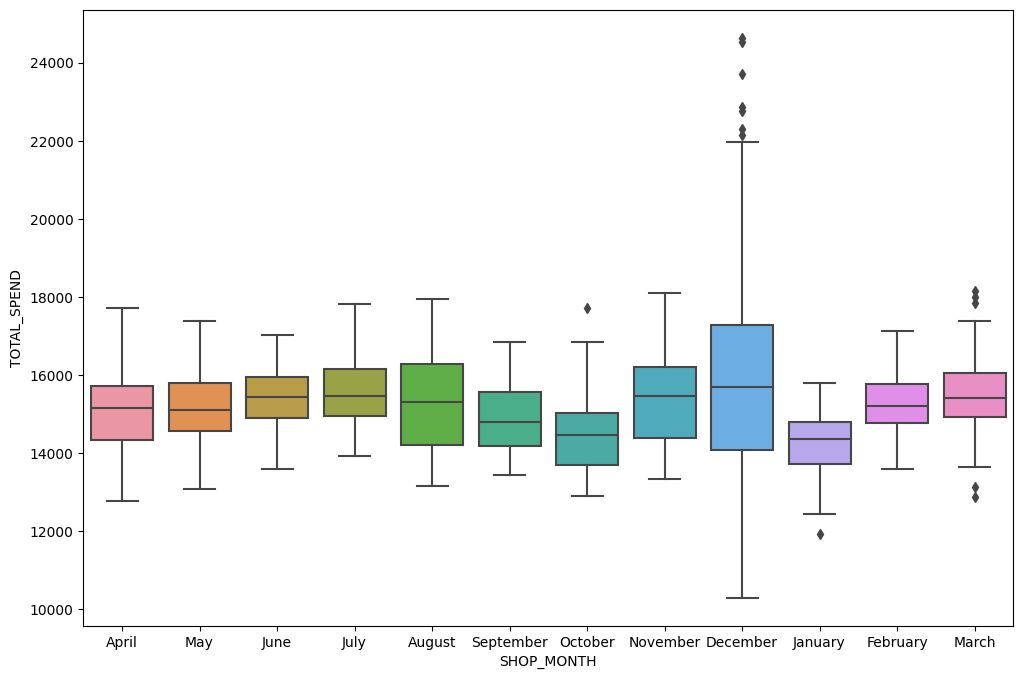

In [105]:
plot_ts_plot(store_ms, 'boxplot', 'MONTH')

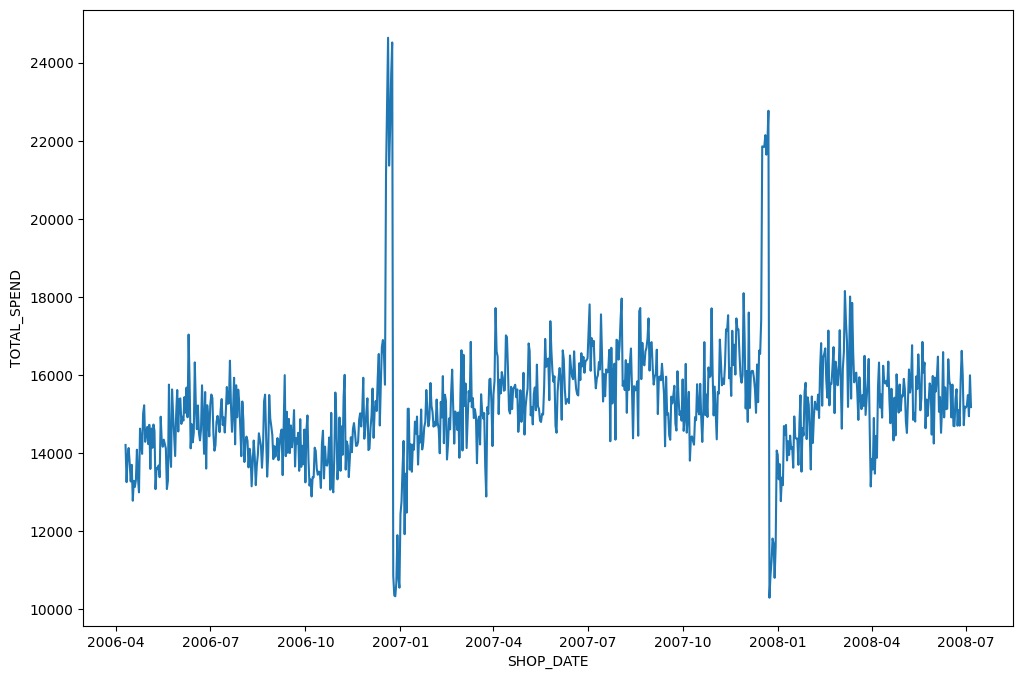

In [106]:
plot_ts_plot(store_ms, 'line', 'DATE')

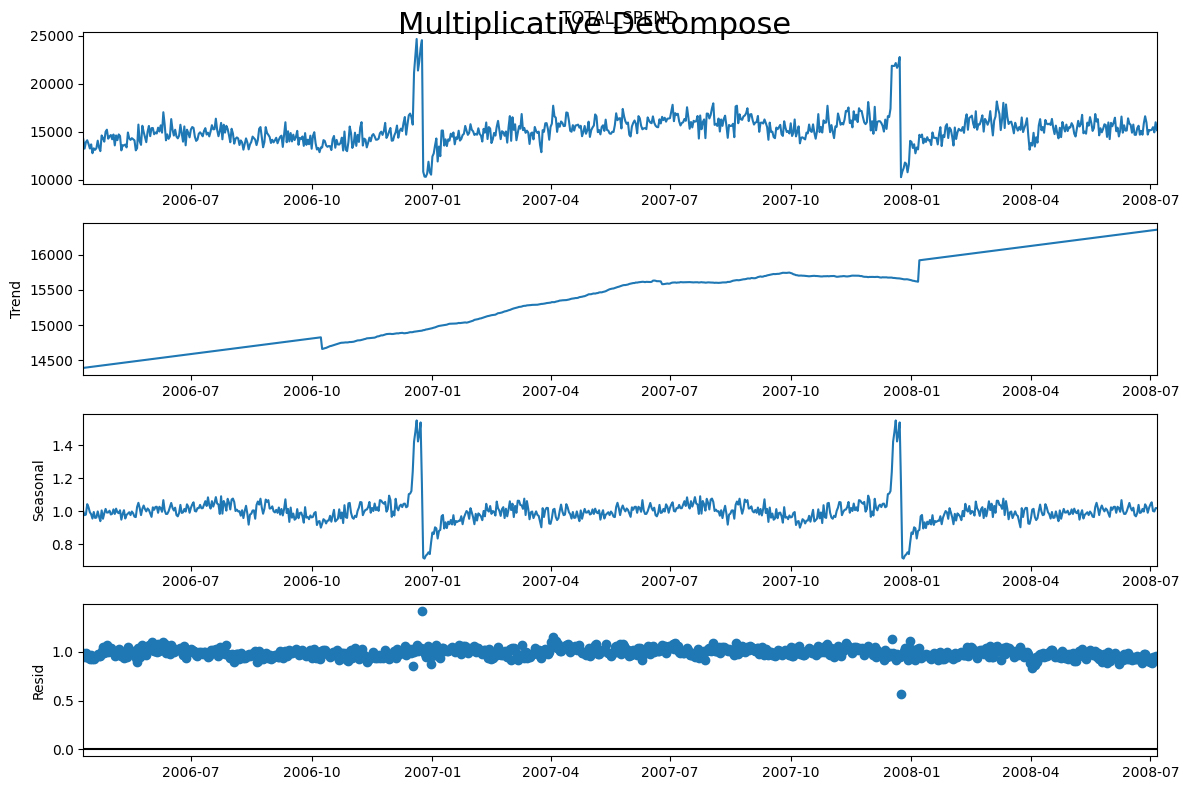

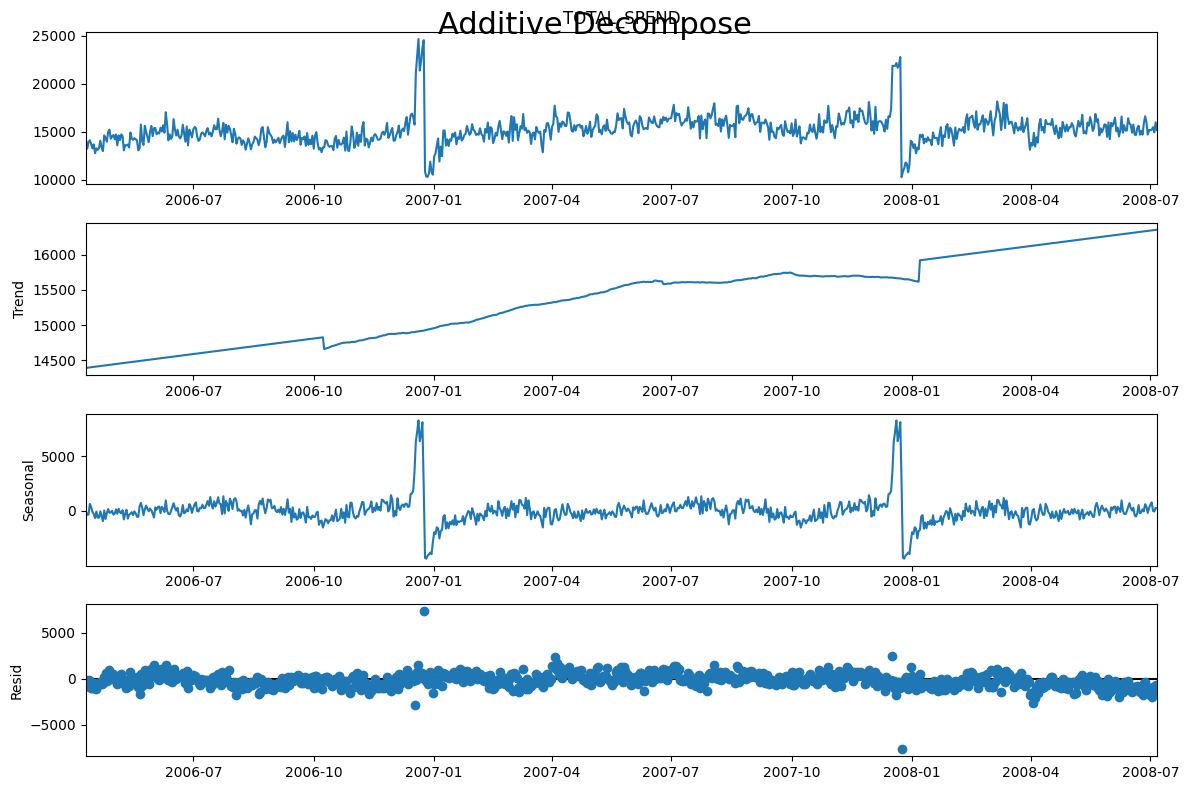

In [107]:
plot_ts_decomposition(store_ms)

MS appears to stationary with a 12 months seasonal component.<br>
No action necessary in pre-processing.

In [108]:
test_stationarity(store_ms)

ADF Statistic: -6.907015321135659
p-value: 1.239784785492572e-09
Reject Null Hypothesis, p-value <= 0.05, time series is stationary
Critial Values:
1%, -3.438448943858302
Critial Values:
5%, -2.8651148002318227
Critial Values:
10%, -2.568673540618808

KPSS Statistic: 1.307488
p-value: 0.010000
Fail to reject Null Hypothesis, p-value <= 0.05, time series is non-stationary
Critial Values:
10%, 0.347
Critial Values:
5%, 0.463
Critial Values:
2.5%, 0.574
Critial Values:
1%, 0.739
Both test indicate a stationary time series


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


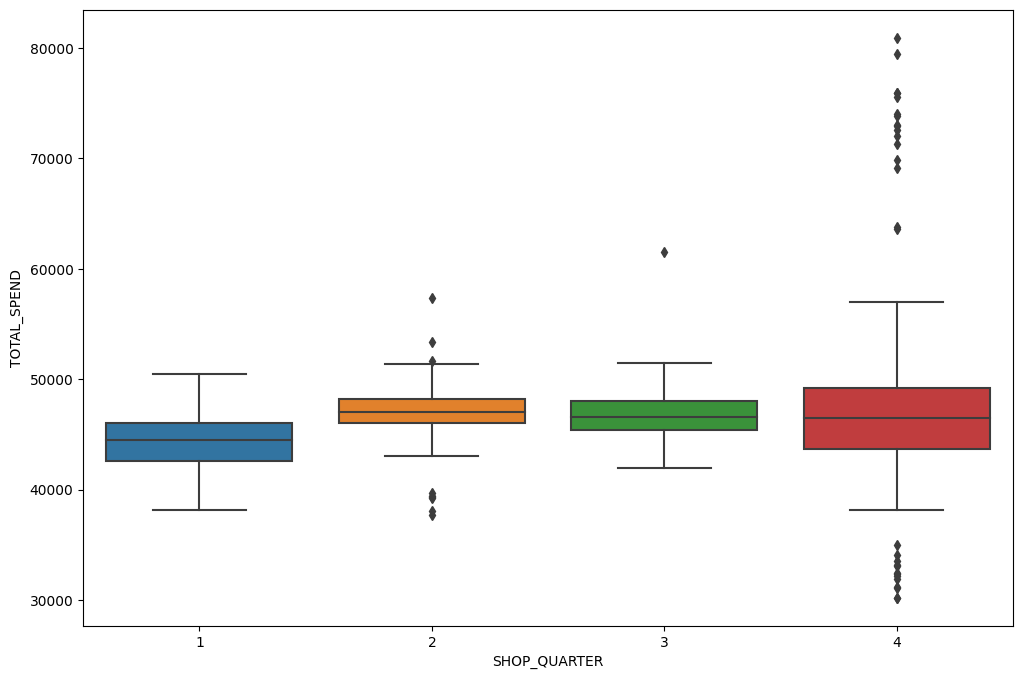

In [109]:
plot_ts_plot(store_ls, 'boxplot', 'QUARTER')

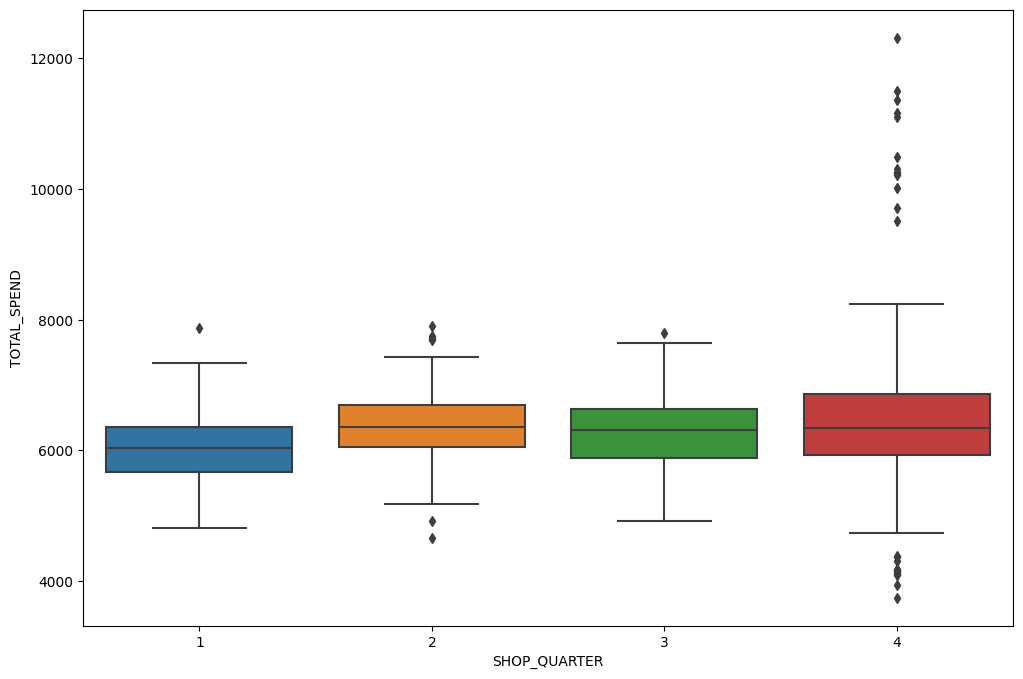

In [110]:
plot_ts_plot(store_xls, 'boxplot', 'QUARTER')

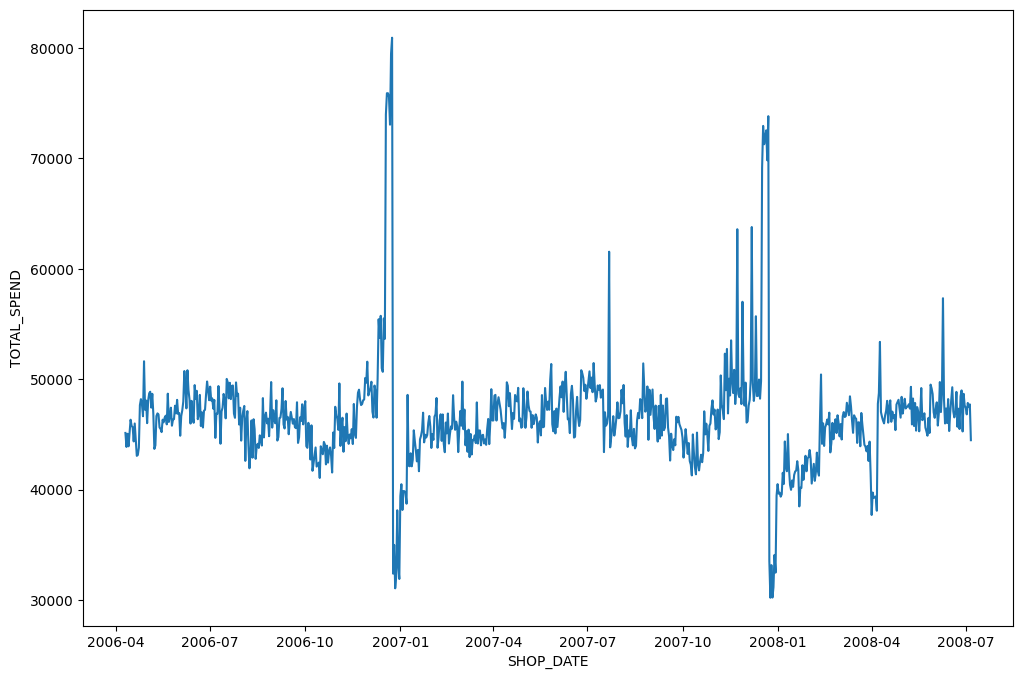

In [111]:
plot_ts_plot(store_ls, 'line', 'DATE')

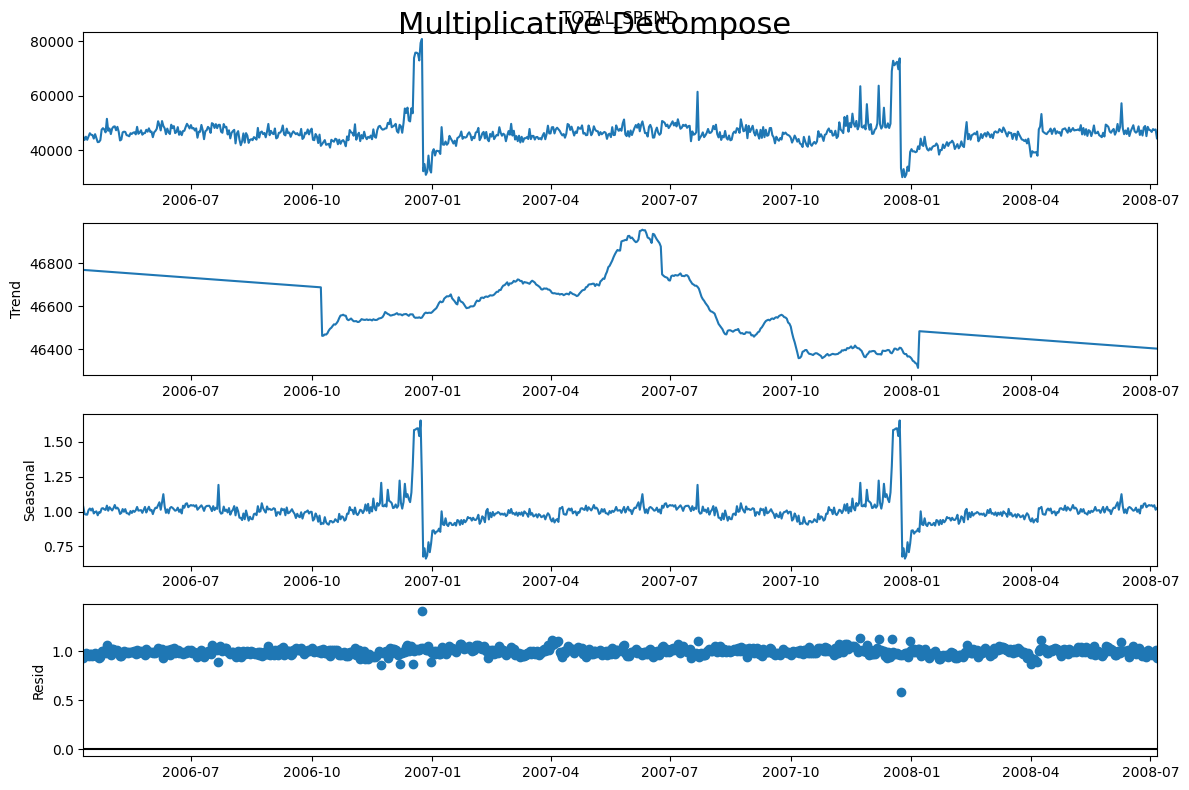

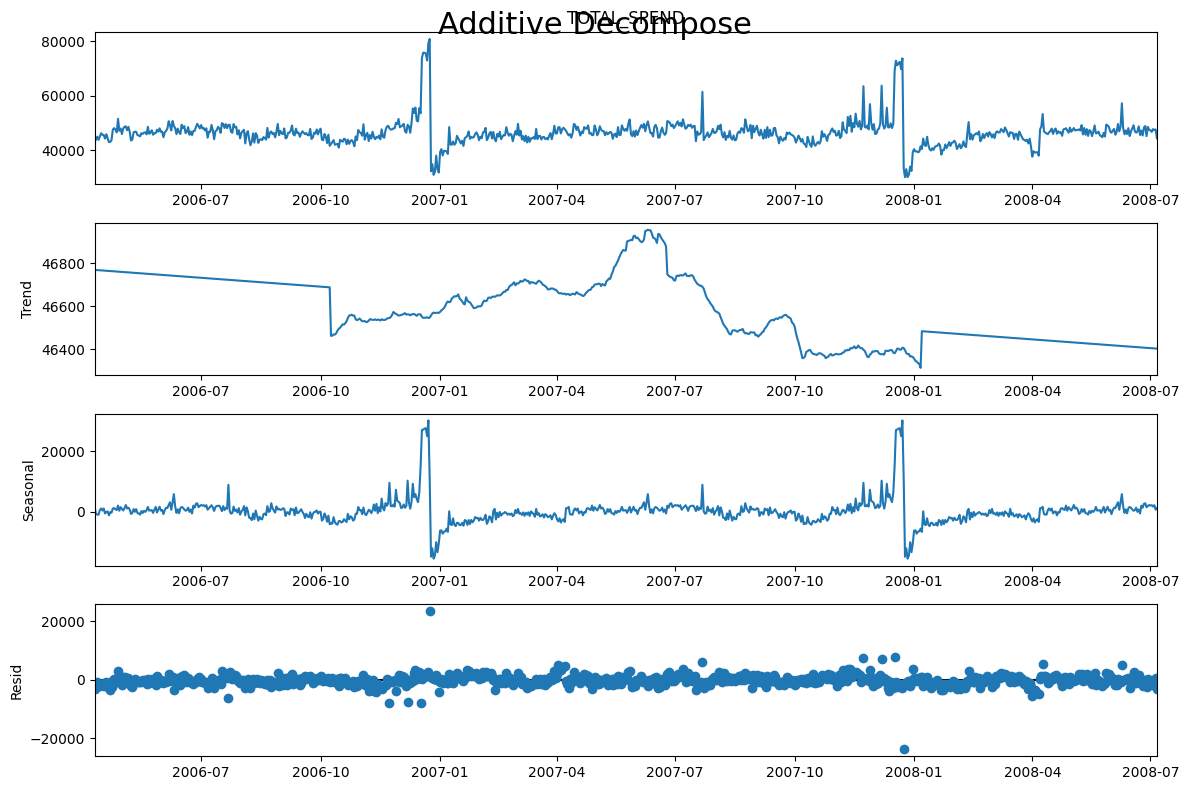

In [112]:
plot_ts_decomposition(store_ls)

LS appears to difference stationary with a 12 months seasonal component.<br>
Its unnecessary to remove seasonality or to de-trend the time series as Auto ARIMA will take care of that.

In [113]:
test_stationarity(store_ls)

ADF Statistic: -5.662570302512584
p-value: 9.307242380693076e-07
Reject Null Hypothesis, p-value <= 0.05, time series is stationary
Critial Values:
1%, -3.4385197724757233
Critial Values:
5%, -2.8651460209504114
Critial Values:
10%, -2.5686901720199313

KPSS Statistic: 0.044626
p-value: 0.100000
Reject Null Hypothesis, p-value > 0.05, time series is stationary
Critial Values:
10%, 0.347
Critial Values:
5%, 0.463
Critial Values:
2.5%, 0.574
Critial Values:
1%, 0.739
TS appears to be difference stationary, consider differencing the overall


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


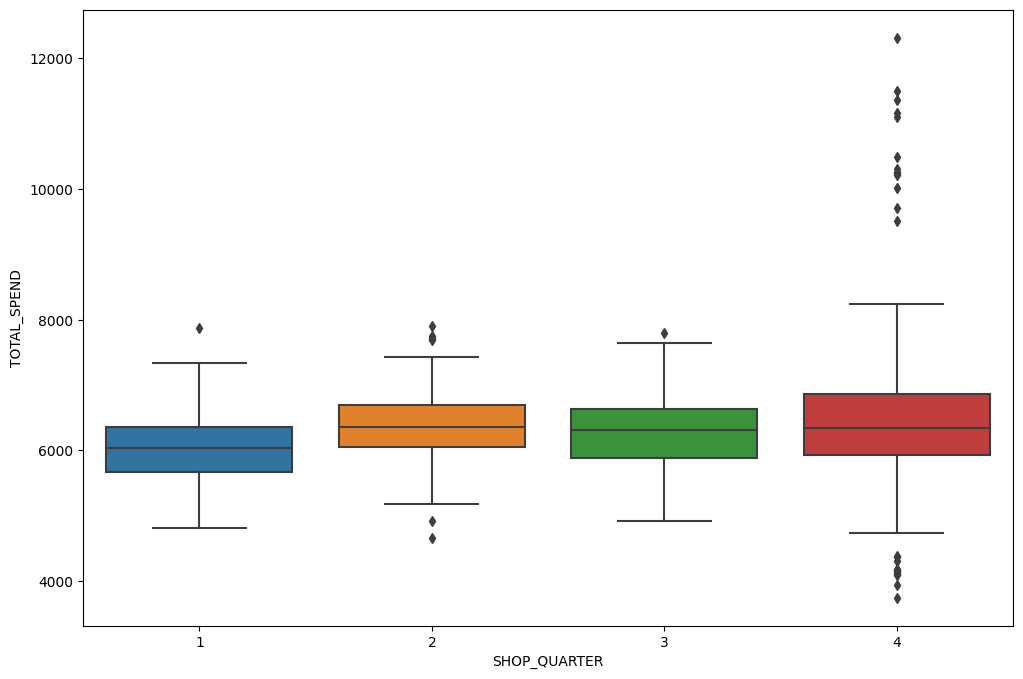

In [114]:
plot_ts_plot(store_xls, 'boxplot', 'QUARTER')

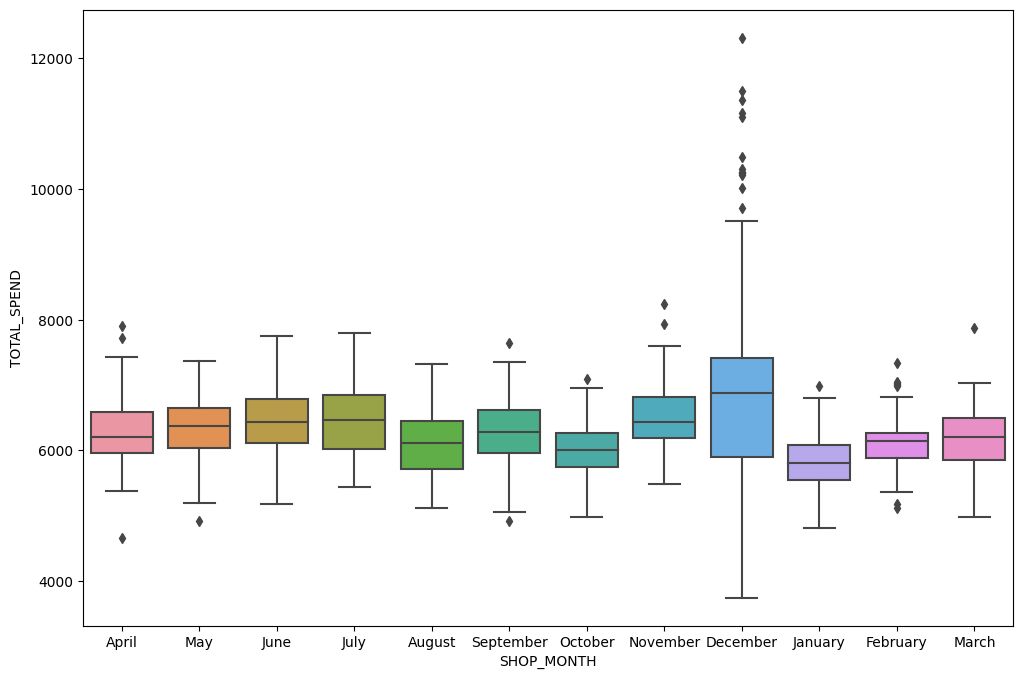

In [115]:
plot_ts_plot(store_xls, 'boxplot', 'MONTH')

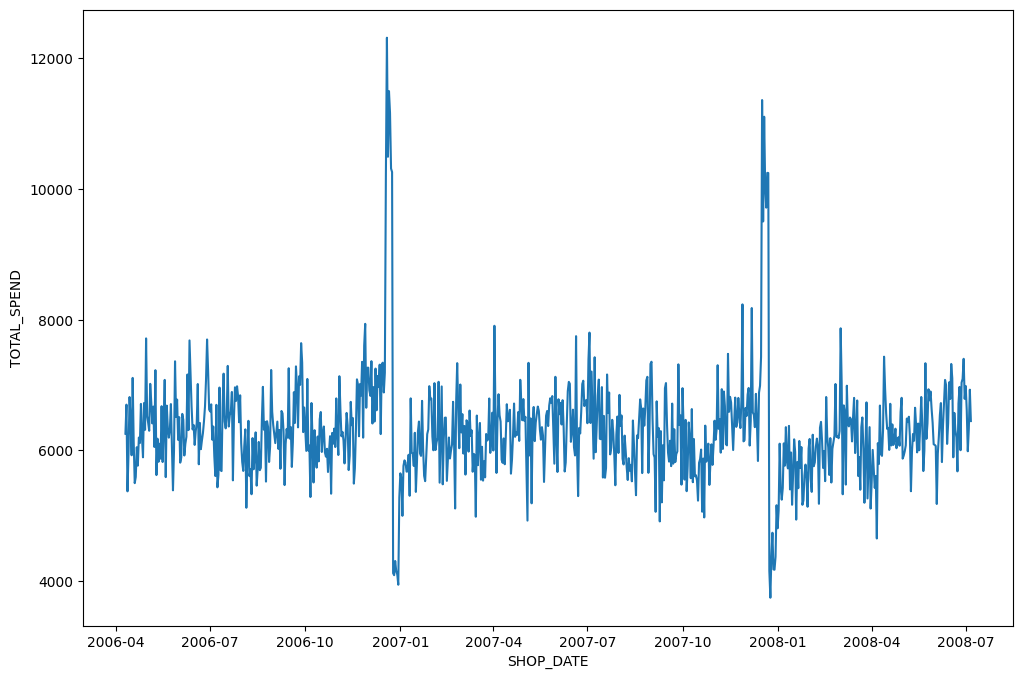

In [116]:
plot_ts_plot(store_xls, 'line', 'DATE')

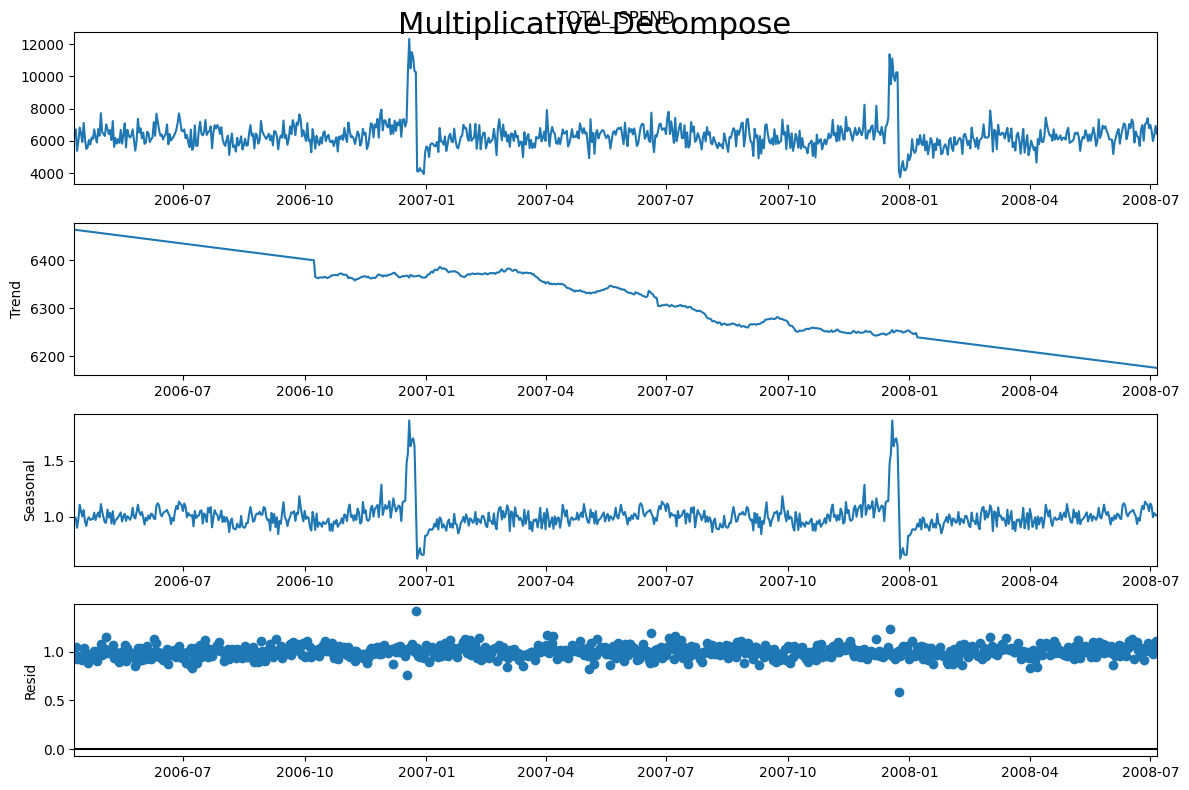

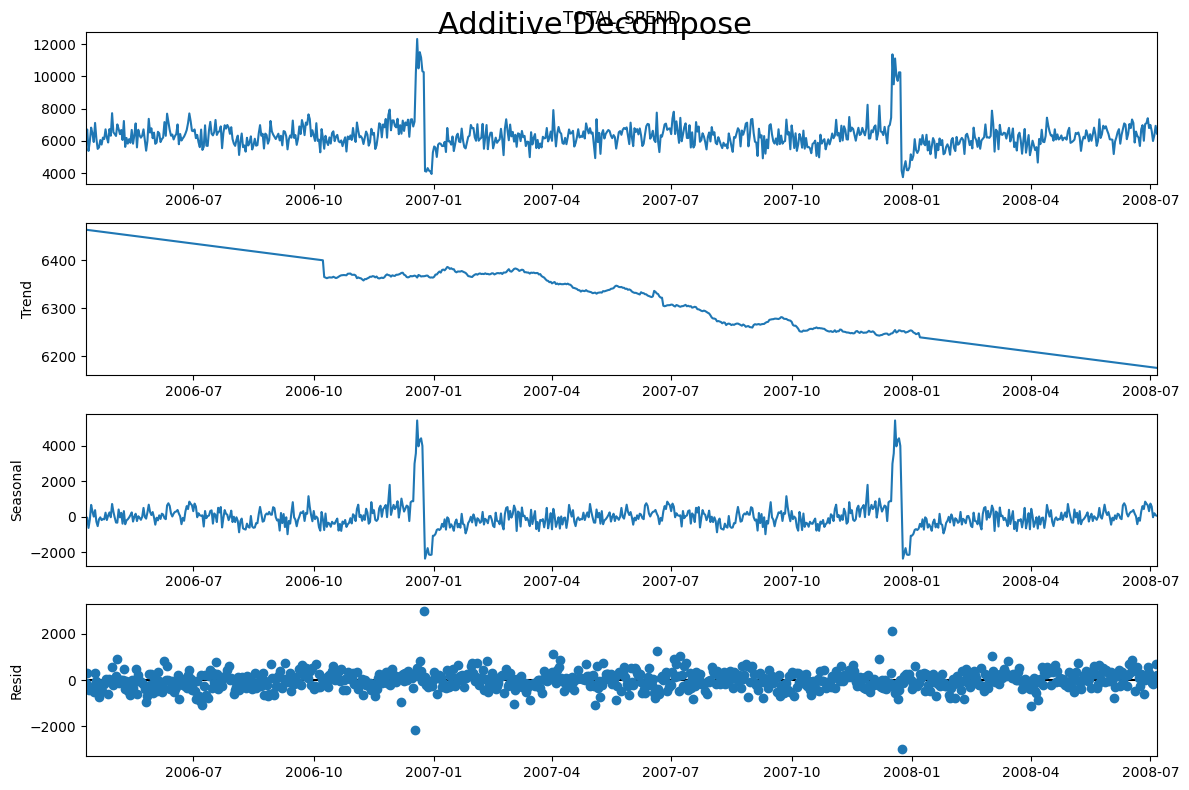

In [117]:
plot_ts_decomposition(store_xls)

XLS appears to difference stationary with a 12 months seasonal component.<br>
Its unnecessary to remove seasonality or to de-trend the time series as Auto ARIMA will take care of that.

In [119]:
test_stationarity(store_xls)

ADF Statistic: -10.026000872408984
p-value: 1.6314719537350395e-17
Reject Null Hypothesis, p-value <= 0.05, time series is stationary
Critial Values:
1%, -3.4384289321263126
Critial Values:
5%, -2.865105979079729
Critial Values:
10%, -2.568668841575869

KPSS Statistic: 0.102118
p-value: 0.100000
Reject Null Hypothesis, p-value > 0.05, time series is stationary
Critial Values:
10%, 0.347
Critial Values:
5%, 0.463
Critial Values:
2.5%, 0.574
Critial Values:
1%, 0.739
TS appears to be difference stationary, consider differencing the overall


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### Dataset Preparation

In [134]:
# Create dataset from store format df with lagged values looking back 6 months
def create_dataset(data, look_back=180):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        a = data.iloc[i:(i+look_back), 0]
        X.append(a)
        Y.append(data.iloc[i + look_back, 0])
    return np.array(X), np.array(Y)

In [168]:
def print_dataset_dims(dataset, dataset_name):
    print(f"# of dataframes for {dataset_name}: {len(store_ss_ts_recs)}")
    print(f"# of observations: {len(store_ss_ts_recs[0])}")
    print(f"# of observations per row: {len(store_ss_ts_recs[0][0])}")
    print(f"# of target values: {len(store_ss_ts_recs[1])}")
    print(f"# of target values per row: {len([store_ss_ts_recs[1][0]])}")

In [169]:
len([store_ss_ts_recs[1][0]])

1

In [191]:
store_ss_ts_recs = create_dataset(store_ss[['TOTAL_SPEND']], 365)
store_ms_ts_recs = create_dataset(store_ms[['TOTAL_SPEND']], 365)
store_ls_ts_recs = create_dataset(store_ls[['TOTAL_SPEND']], 365)
store_xls_ts_recs = create_dataset(store_xls[['TOTAL_SPEND']], 365)

### All sets of observations contain 638 rows with a lag of 180 days

In [171]:
print_dataset_dims(store_ss, "SS Stores")

# of dataframes for SS Stores: 2
# of observations: 638
# of observations per row: 180
# of target values: 638
# of target values per row: 1


In [172]:
print_dataset_dims(store_ms, "MS Stores")

# of dataframes for MS Stores: 2
# of observations: 638
# of observations per row: 180
# of target values: 638
# of target values per row: 1


In [173]:
print_dataset_dims(store_ls, "LS Stores")

# of dataframes for LS Stores: 2
# of observations: 638
# of observations per row: 180
# of target values: 638
# of target values per row: 1


In [174]:
print_dataset_dims(store_xls, "XLS Stores")

# of dataframes for XLS Stores: 2
# of observations: 638
# of observations per row: 180
# of target values: 638
# of target values per row: 1


# Splitting into train and test

In [184]:
def get_train_and_test_data(dataset):
    # 
    look_back = 180
    X = dataset[0]
    y = dataset[1]

    # Splitting data 80/20 for train and test
    train_size = int(len(X) * 0.8)
    train_X, test_X = X[:train_size], X[train_size:]
    train_y, test_y = y[:train_size], y[train_size:]
    
    return train_X, test_X, train_y, test_y

In [186]:
store_ss_train_X, store_ss_test_X, store_ss_train_y, store_ss_test_y = get_train_and_test_data(store_ss_ts_recs)
store_ms_train_X, store_ms_test_X, store_ms_train_y, store_ms_test_y = get_train_and_test_data(store_ms_ts_recs)
store_ls_train_X, store_ls_test_X, store_ls_train_y, store_ls_test_y = get_train_and_test_data(store_ls_ts_recs)
store_xls_train_X, store_xls_test_X, store_xls_train_y, store_xls_test_y = get_train_and_test_data(store_xls_ts_recs)

# Training ARIMA
Using ARIMA as the baseline model.<br>
To avoid the need for differencing and hyperparameter tuning for pdq just use auto-arima.  
If needed, I will build a loop to try multiple values for p, d, & q values.

In [192]:
def train_auto_arima_model(training_data):
    # Seasonal differentiation is added due to the known seasonality in December
    auto_arima_model = auto_arima(training_data, seasonal=True, m=12, trace=True)
    auto_arima_model.fit(training_data)
    return auto_arima_model

In [176]:
def predict_arima(model, look_forward):
    return model.predict(n_periods=look_forward)

In [207]:
def evaluate_model_predictions(predictions, actual):
    mse = mean_squared_error(actual, predictions)
    mae = mean_absolute_error(actual, predictions)
    rmse = mean_squared_error(actual, predictions, squared=False)
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')

In [193]:
# We will be using the time series models to predict the last 30, 60, 90 days using n-90 days
arima_train_ss = store_ss[['TOTAL_SPEND']].iloc[:len(store_ss)-90]
arima_test_ss = store_ss[['TOTAL_SPEND']].iloc[len(store_ss)-90:]

In [194]:
arima_model_ss = train_auto_arima_model(arima_train_ss)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=10997.109, Time=1.50 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=11229.747, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=11104.874, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=11024.650, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=11227.748, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=10992.918, Time=1.47 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=10993.139, Time=0.41 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=10994.942, Time=3.84 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=10993.500, Time=1.28 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=4.29 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=11003.062, Time=1.27 sec
 ARIMA(3,1,2)(0,0,1)[12] intercept   : AIC=10991.291, Time=1.47 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=10990.563, Time=0.43 sec
 ARIMA(3,1,2)(1,0

In [196]:
arima_model_ss_predict_30 = predict_arima(arima_model_ss, 30)
arima_model_ss_predict_60 = predict_arima(arima_model_ss, 60)
arima_model_ss_predict_90 = predict_arima(arima_model_ss, 90)

In [200]:
arima_test_ss_30 = arima_test_ss.iloc[:30]
arima_test_ss_60 = arima_test_ss.iloc[:60]
arima_test_ss_90 = arima_test_ss.iloc[:90]

In [208]:
evaluate_model_predictions(arima_test_ss_30, arima_model_ss_predict_30)

MSE: 148710.89583898467
MAE: 313.05997819550623
RMSE: 385.6305172558114


In [209]:
evaluate_model_predictions(arima_test_ss_60, arima_model_ss_predict_60)

MSE: 132378.52112674393
MAE: 282.7774068316441
RMSE: 363.83859213495197


In [210]:
evaluate_model_predictions(arima_test_ss_90, arima_model_ss_predict_90)

MSE: 122179.41258818192
MAE: 269.7437835341625
RMSE: 349.54171795106504
